In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

In [2]:
X, y = make_moons(800, noise=0.17)
y[y==0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

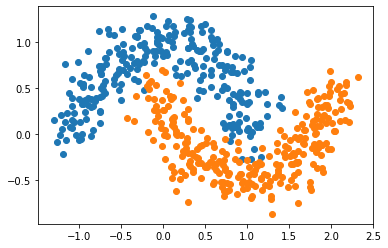

In [3]:
plt.scatter(X_train[y_train==-1, 0], X_train[y_train==-1, 1])
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1])
plt.show()

In [4]:
# clf = SVC(kernel='rbf')
# clf.fit(X_train, y_train)

# pred_y = clf.predict(X_test)

# print(classification_report(y_test, pred_y, digits=3))

In [5]:
gs = GridSearchCV(SVC(), {
    'C': [0.5, 1, 10, 20, 50, 100],
    'gamma': ['scale', 'auto', 0.1, 0.5, 0.8, 0.9]
})
gs.fit(X_train, y_train)
clf = gs.best_estimator_
print('Best estimator:', clf)

res = pd.DataFrame(gs.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
res[['param_C', 'param_gamma', 'mean_test_score', 'std_test_score']].head()

Best estimator: SVC(C=20)


,param_C,param_gamma,mean_test_score,std_test_score
18,20,scale,0.981308,0.013217
23,20,0.9,0.981308,0.013217
22,20,0.8,0.981308,0.013217
12,10,scale,0.979457,0.010917
30,100,scale,0.979457,0.010917


In [6]:
pred_y = clf.predict(X_test)
print(classification_report(y_test, pred_y, digits=3))

              precision    recall  f1-score   support

          -1      0.993     1.000     0.996       139
           1      1.000     0.992     0.996       125

    accuracy                          0.996       264
   macro avg      0.996     0.996     0.996       264
weighted avg      0.996     0.996     0.996       264



In [7]:
def get_kernel_matrix(x_probe, mpy=True, gamma=clf._gamma):
    km = rbf_kernel(clf.support_vectors_, x_probe, gamma=gamma)
    if mpy:
        km *= y_train[clf.support_].reshape(-1, 1)
    return km

def find_tipping_point(x_probe, beyond_end=5):
    km = get_kernel_matrix(x_probe, False)

    def ksvm_label_flip(inds):
        prev = clf.predict(x_probe)[0]
        # Create coefficient backup
        backup = np.copy(clf._dual_coef_)
        # Flip labels
        clf._dual_coef_[0, inds] = -clf._dual_coef_[0, inds]
        # Check prediction
        after = clf.predict(x_probe)[0]
        # Restore coefficients
        clf._dual_coef_ = backup
        return prev, after

    # Find the tipping point
    label_flip_len = -1
    inds = np.flip(km.argsort(axis=0).flatten())
    for i in range(1, len(inds)+1):
        p, a = ksvm_label_flip(inds[:i])
        if p != a:
            label_flip_len = i
            # print("Label flips:", label_flip_len := i)
            inds = inds[:label_flip_len + beyond_end]
            break
    return km, clf.support_[inds], label_flip_len


In [8]:
@interact(
    x1=FloatSlider(min=-1.5, max=1.5, step=0.01, value=0, continuous_update=False),
    x2=FloatSlider(min=-1.5, max=1.5, step=0.01, value=0, continuous_update=False),
)
def calculate(x1=0, x2=0):
    x_probe = np.array([[x1, x2]])
    km, inds, label_flip_len = find_tipping_point(x_probe, 0)
    res = clf.predict(x_probe)[0]
    print(f'Predict: {res}, # flips: {label_flip_len}')
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], label='-1', alpha=0.5)
    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='+1', alpha=0.5)
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], label='support')
    plt.scatter(X_train[inds, 0], X_train[inds, 1], label='flipped')
    plt.scatter(x_probe[:, 0], x_probe[:, 1], color='black', label='probe')
    plt.xlabel('x1')
    plt.ylabel('x2')
    # plt.axis([-1.5, 1.5, -1.5, 1.5])
    plt.legend()
    plt.show()


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x1', max=1.5, min=-1.5, ste…